In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
class Model():
    def __init__(self, H, C, LR, Mom = 0, K = 5, temp=1):
        self.H = H
#         print "H:",self.H
        self.C = C
#         print "C:",self.C
        self.LR = LR
#         print "LR:",self.LR
        self.K = K
#         print "K:",self.K
        self.temp = temp
#         print "Temp:",self.temp
        self.Mom = Mom
#         print "Mom:",self.Mom
        wxh_xav = (6**0.5)/((C+H)**0.5)
        self.Wxh = np.random.uniform(-wxh_xav,wxh_xav,(C,H))
#         print "Wxh:",self.Wxh, self.Wxh.shape
        self.Wxh_mom = np.zeros((C,H),dtype=float)
#         print "Wxh_mom:",self.Wxh_mom, self.Wxh_mom.shape
        whh_xav = (6**0.5)/((H+H)**0.5)
        self.Whh = np.random.uniform(-whh_xav,whh_xav,(H,H))
#         print "Whh:",self.Whh, self.Whh.shape
        self.Whh_mom = np.zeros((H,H),dtype=float)
#         print "Whh_mom:",self.Whh_mom, self.Whh_mom.shape
        who_xav = (6**0.5)/((C+H)**0.5)
        self.Who = np.random.uniform(-who_xav,who_xav,(H,C))
#         print "Who:",self.Who, self.Who.shape
        self.Who_mom = np.zeros((H,C),dtype=float)
#         print "Who_mom:",self.Who_mom, self.Who_mom.shape
        pass

    def vis(self, test_string):
        x = np.zeros((len(test_string),self.C),dtype=float)
        for i in range(len(test_string)):
            x[i,ord(test_string[i])]=1
        ans = np.matrix(self.forward(x))
        n,m = ans.shape
        out_string = ""
        confidence = []
        for i in range(n):
            max_prob = ans[i,0]
            for j in range(m):
                if ans[i,j] > max_prob:
                    max_prob = ans[i,j]
                    c = j
            out_string += chr(c)
            confidence.append(max_prob)
        return out_string, confidence


    def softmax(self, x):
        e = np.exp(x)
        sum_e = np.sum(e)
        return e/sum_e
    
    def softmax_t(self, x):
        x = x*self.temp
        e = np.exp(x)
        sum_e = np.sum(e)
        return e/sum_e


    def forward(self, X):
        self.X = np.matrix(X)
        i = 0
        self.s = np.zeros((len(X)+1,self.H))
        self.O_soft = np.zeros((len(X),self.C))
        for x in X:
            x = np.matrix(x)
            # print "x ",x,x.shape
            s_prev = self.s[i-1]
            # print "s_prev ", s_prev, s_prev.shape
            h_1 = np.matmul(x,self.Wxh)
            # print "h_1 ", h_1, h_1.shape
            h_2 = np.matmul(s_prev,self.Whh)
            # print "h_2 ", h_2, h_2.shape
            h_12 = h_1 + h_2
            # print "h_12 ", h_12, h_12.shape
            s_curr = np.tanh(h_12)
            # print "s_curr ", s_curr, s_curr.shape
            o = np.matmul(s_curr,self.Who)
            o /= self.temp
            # print "o ", o, o.shape
            o_soft = self.softmax(o)
            # print "o_soft ", o_soft, o_soft.shape
            self.s[i] = s_curr
            self.O_soft[i] = o_soft
            i+=1
        return self.O_soft


    def loss(self, out, T):
        # Cross-Entropy Loss
        self.T = np.matrix(T)
        self.loss_val = -np.multiply(np.log(out),T)
        # print self.loss_val
        return self.loss_val.sum()


    def backward(self):
        self.dE_dWho = np.zeros((self.H,self.C),dtype=float)
        self.dE_dWxh = np.zeros((self.C,self.H),dtype=float)
        self.dE_dWhh = np.zeros((self.H,self.H),dtype=float)
        
        I = np.identity(self.C)
        for i in range(len(self.X)):
            
            error =np.matrix(self.loss_val[i])
            o_soft = np.matrix(self.O_soft[i])
            s_curr = np.matrix(self.s[i])
            
            
            # E = -log(o_soft_j)                where j==target

            # dE/d(o_soft_j) = -1/o_soft_j      if j==target
            #                = 0                otherwise
            dE_dosoft  = np.zeros((1,self.C))                                        # 1XC
            
            for j in range(self.C):
                if error[0,j] != 0:
                    dE_dosoft[0,j] = -1.0/o_soft[0,j]
                    break                    

            # d o_soft_j/ do_i  = o_soft_j - o_soft_j*o_soft_i   if i==j
            #                   = - o_soft_j*o_soft_i            otherwise
            diag_o_soft = np.multiply(I, o_soft)

            dosoft_do	= diag_o_soft - np.matmul(o_soft.T,o_soft)				# CXC

            dE_do 		= np.matmul(dE_dosoft, dosoft_do)						# 1XC
            
            # d o / dWho = s_t
            do_dWho		= np.matrix(s_curr)										# 1XH
    
            self.dE_dWho	+= np.matmul(do_dWho.T, dE_do)						# HXC
            
            # d o / d s_T = Who
            do_ds		= self.Who 												# HXC
            
            dE_ds 		= np.matmul(dE_do, do_ds.T)								# 1XH
            # s_T = tanh(h1+h2)
            # d s_T / d (h1+h2) = 1 - s_T**2
            ds_dh12		= np.ones((1,self.H)) - np.multiply(s_curr,s_curr)		# 1XH

            dE_dh12		= np.multiply(dE_ds,ds_dh12)							# 1XH
            
            dh12_dh1	= 1
            dh12_dh2	= 1
            
            dE_dh1 		= dE_dh12												# 1XH
            dE_dh2 		= dE_dh12												# 1XH
            
            #  Going back in time            
            for time_step in range(i, max(-1,i-self.K-1),-1):
                
                s_prev = np.matrix(self.s[time_step-1])
                x_curr = np.matrix(self.X[time_step])
                
                # d h1/ d Whh = x_T
                                
                dh1_dWxh		= np.matrix(x_curr) 							# 1xC
                
                self.dE_dWxh	+= np.matmul(dh1_dWxh.T, dE_dh12)				# CXH
                
                
                # d h2/ d Whh = s_(T-1)
                dh2_dWhh 		= np.matrix(s_prev) 							# 1XH
                
                self.dE_dWhh	+= np.matmul(dh2_dWhh.T, dE_dh12)				# HXH
                
                eq1 = np.ones((1,self.H)) - np.multiply(s_prev,s_prev)
                eq2 = np.matmul(dE_dh12, self.Whh.T)
                
                dE_dh12 = np.multiply(eq1,eq2)

            pass


    def step(self):
        self.Who -= np.multiply(self.LR, self.dE_dWho)
        self.Wxh -= np.multiply(self.LR, self.dE_dWxh)
        self.Whh -= np.multiply(self.LR, self.dE_dWhh)       
#         self.Who_mom  = np.multiply((1-self.Mom),self.dE_dWho) + np.multiply(self.Mom,self.Who_mom)
#         self.Who 		= self.Who + np.multiply(self.LR,self.Who_mom)
#         self.Wxh_mom  = np.multiply((1-self.Mom),self.dE_dWxh) + np.multiply(self.Mom,self.Wxh_mom)
#         self.Wxh 		= self.Wxh + np.multiply(self.LR,self.Wxh_mom)
#         self.Whh_mom  = np.multiply((1-self.Mom),self.dE_dWhh) + np.multiply(self.Mom,self.Whh_mom)
#         self.Whh 		= self.Whh + np.multiply(self.LR,self.Whh_mom)
        pass

In [3]:
X = np.genfromtxt('one_hot_1_short.csv', delimiter=',')
T = X[1:]
X = X[:-1]

In [4]:
text = "hello"
def train(epochs, K, e_min = 0.0001):
    global text
    train_loss = []
    N = len(X)
    for epoch in range(epochs):
        avg_loss = 0.0
        i = 0        
        while i < N:
            x = X[i:min(N,i+K)]
            t = T[i:min(N,i+K)]
            out = model.forward(x)
            error = model.loss(out, t)
            model.backward()
            model.step()
            avg_loss += error
            i += K
        avg_loss = avg_loss/float(N)
        train_loss.append(avg_loss)
        
        if (epoch+1)%10 == 0:
            print "After Epoch",epoch+1,avg_loss
        
        if (epoch+1)%20 == 0:
            print "Visualistion of Input", text
            out_str, confidence = model.vis(text)
            print out_str, " With confidence per character ", confidence

        if avg_loss < e_min:
            print "Train Loss ",avg_loss
            return train_loss
    print "Train Loss ",avg_loss
    return train_loss

The history saving thread hit an unexpected error (OperationalError('attempt to write a readonly database',)).History will not be written to the database.


Train Loss  0.010598896496203332


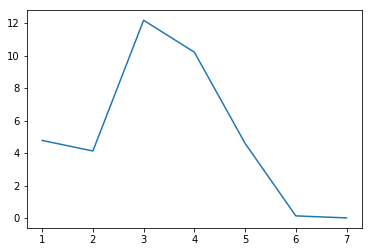

In [5]:
K = 10
epochs = 50
LR = 0.1
H = 50
C = 256
temp = 1
Mom = 0.1
e_min = 0.1
model = Model(H,C,LR,Mom, K, temp)
train_loss = train(epochs,K,e_min)
plt.plot(range(1,len(train_loss)+1),train_loss)

Train Loss  0.00804850715304372


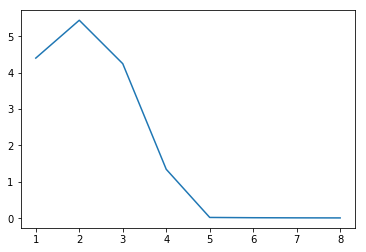

In [6]:
K = 10
epochs = 50
LR = 0.1
H = 50
C = 256
temp = 1
Mom = 0.1
e_min = 0.01
model = Model(H,C,LR,Mom, K, temp)
train_loss = train(epochs,K,e_min)
plt.plot(range(1,len(train_loss)+1),train_loss)

After Epoch 10 2.4924841408591147
After Epoch 20 1.4624340943087712
Visualistion of Input hello
ello   With confidence per character  [0.9999989863527998, 0.9999984672550415, 0.9974940415071573, 0.9999619954604165, 0.9997582358686957]
Train Loss  0.003936797644836627


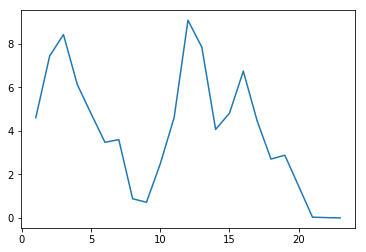

In [7]:
K = 10
epochs = 200
LR = 0.1
H = 50
C = 256
temp = 1
Mom = 0.1
e_min = 0.01
model = Model(H,C,LR,Mom, K, temp)
train_loss = train(epochs,K,e_min)
plt.plot(range(1,len(train_loss)+1),train_loss)

After Epoch 10 0.012605630384772137
After Epoch 20 0.004429326303656715
Visualistion of Input hello
ello   With confidence per character  [0.9700215047310274, 0.9992723638182301, 0.9997125528788259, 0.9990519755641526, 0.9999563645900439]
After Epoch 30 0.002638932791142967
After Epoch 40 0.0018651655620852247
Visualistion of Input hello
ello   With confidence per character  [0.9875297352170871, 0.9996139428046394, 0.9998465998097384, 0.9995637122615981, 0.9999806966394468]
After Epoch 50 0.0014362943670365798
After Epoch 60 0.0011647290990519186
Visualistion of Input hello
ello   With confidence per character  [0.9922683638051994, 0.9997350601235219, 0.9998922768043107, 0.9997167301930575, 0.9999874704452493]
Train Loss  0.0009937984963386847


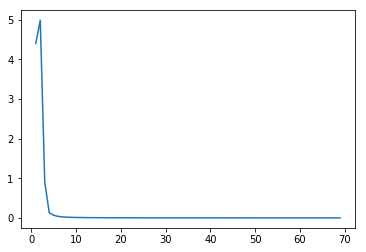

In [8]:
K = 10
epochs = 200
LR = 0.08
H = 50
C = 256
temp = 1
Mom = 0.1
e_min = 0.001
model = Model(H,C,LR,Mom, K, temp)
train_loss = train(epochs,K,e_min)
plt.plot(range(1,len(train_loss)+1),train_loss)